<span style="font-size: 30px;">Is there evidence suggesting that the location of a property influences its price to size, number of bathrooms, or number of bedrooms ratio, and can we model the price of homes on these variables?</span>

<span style="font-size: 15px;">ECO225 Project 1 2024 By Samuel Ahn</span>
<span style="font-size: 15px;">1009008967, ahnsamue, sam.ahn@mail.utoronto.ca</span>

<span style="font-size: 30px;">Introduction:</span>

The United States real estate market has consistantly been a high-focus area for economic research. Given the importance of a home, as both a major financial asset and a residential property, being able to model the market has been the goal of both researchers and private institutions for as long as the market has existed CITE. Using data collected by Ahmed Shahriar Sakib from Realtor.com (https://www.realtor.com/), this paper will aim to distinguish preferences for home qualities across America, and use said information to predict the market value of a home given it's characteristics. 

<span style="font-size: 30px;">Data Cleaning/Loading:</span>

In [23]:
#import libraries   
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from IPython.display import display, HTML

In [3]:
#read dataset and convert into a dataframe object
realtor= pd.read_csv("realtor-data.csv")
df=realtor.copy()

There are two steps to clean the data, being removing houses that are currently listed as "ready to build" instead of on the market, as the reported information about them is significantly more speculative, and then adding a dummy variable representing if the house has been sold before. The first step will allow for more conclusive results to the study, and will not significantly impact the amount of data available the analyze. The second step will help us create figures and histograms later within the paper. 

In [28]:
#Adding a dummy variable representing if a house has been sold before
df["sold_before"]=np.where(df.prev_sold_date.isnull(),0,1)

This is what the dataset currently looks like:

In [29]:
#inspect dataset
df.head()

,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price,sold_before
0,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0,0
1,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0,0
2,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0,0
3,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0,0
4,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0,0


<span style="font-size: 30px;">Summary Statistics Tables:</span>

In [52]:
#printing summary statistics for numerical columns
additional_stats = {
    'Mode': df[['bed','bath','acre_lot','house_size','price']].mode().iloc[0],
    'Variance': df[['bed','bath','acre_lot','house_size','price']].var(),
    'Skewness': df[['bed','bath','acre_lot','house_size','price']].skew(),
    'Kurtosis': df[['bed','bath','acre_lot','house_size','price']].kurtosis()
}

summary_stats = pd.concat([df[['bed','bath','acre_lot','house_size','price']].describe(), pd.DataFrame(additional_stats).T])

display(HTML('<div style="font-size: 20px">Table 1: Summary Statistics of Data</div>'))
display(summary_stats.T)

,count,mean,std,min,25%,50%,75%,max,Mode,Variance,Skewness,Kurtosis
bed,1182606.0,3.393161,2.053180e+00,1.0,2.00,3.00,4.00,123.0,3.00,4.215547e+00,9.233093,321.527161
bath,1206853.0,2.487426,1.873599e+00,1.0,2.00,2.00,3.00,198.0,2.00,3.510373e+00,28.002643,2490.707721
acre_lot,1043599.0,32.150131,1.249983e+03,0.0,0.12,0.32,1.34,100000.0,0.06,1.562457e+06,61.960484,4293.465563
house_size,949022.0,2177.853815,3.495979e+03,4.0,1168.00,1700.00,2500.00,1450112.0,1200.00,1.222187e+07,117.847213,34997.372493
price,1399097.0,818471.244103,2.684814e+06,0.0,235000.00,445000.00,795000.00,875000000.0,599000.00,7.208225e+12,177.969780,56353.590247


Table 1 displays several interesting and important qualities of the data. Something immediately noticeable is the extreme skewness of every variable, but especially the price and house size variables. All variables are also extremely leptokurtic, signifying the possible presence of outliers. This point will be returned to before data-visualization begins, as the kurtosis is large enough to have a negative impact on readability of figures and plots. In terms of values and in-context analysis, it is possible that these data include information about non-single family homes, as the max values of 123 bedrooms and 198 bathrooms hints towards multi-residential buildings. Another very interesting thing to notice is the extremely small median for acre_lot given its mean and standard deviation. This again points towards the presence of extreme outliers that may need to be dealt with before visualization. The final important takeaway from these simple sample statistics is the amount of missing data. The variable with the most missing entries is house_size, followed closely by acre_lot. This may present itself as an issue in the future, and thus should be noted. 

Due to these signs of extreme outliers, a new dataframe object will be created with said outliers removed. This dataframe will be used for visualizations that are negatively impacted by the outliers. The metric used to determine an extreme outlier within this dataset will be the interquartile range (IQR). The IQR method is used instead of z-scores due to the skewed distribution of the data. An 'extreme outlier' in this paper represents a datapoint with a value for any of the 5 variables presented in Table 1 that is either below 3 IQRs from the 25th percentile, or above 3 IQRs from the 75th percentile. This should prevent removing too much of the data. 

In [55]:
#identifying which variables we would like to remove outliers for
columns_to_remove_outliers = {'bed','bath','acre_lot','price','house_size'}

#we create a version of our data without extreme outliers for plotting 
data = df.copy()

for column in columns_to_remove_outliers:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = (df[column] < (Q1 - 3 * IQR)) | (df[column] > (Q3 + 3 * IQR))
    data = data.loc[~outliers_iqr]

#printing summary statistics for new cropped data
additional_stats_no_outliers = {
    'Mode': data[['bed','bath','acre_lot','house_size','price']].mode().iloc[0],
    'Variance': data[['bed','bath','acre_lot','house_size','price']].var(),
    'Skewness': data[['bed','bath','acre_lot','house_size','price']].skew(),
    'Kurtosis': data[['bed','bath','acre_lot','house_size','price']].kurtosis()
}

summary_stats_no_outliers = pd.concat([data[['bed','bath','acre_lot','house_size','price']].describe(), pd.DataFrame(additional_stats_no_outliers).T])

display(HTML('<div style="font-size: 20px">Table 2: Summary Statistics With Extreme Outliers Removed</div>'))
display(summary_stats_no_outliers.T)


,count,mean,std,min,25%,50%,75%,max,Mode,Variance,Skewness,Kurtosis
bed,1048780.0,3.199828,1.499307,1.0,2.00,3.00,4.00,10.0,3.00,2.247921e+00,1.038761,2.006444
bath,1072639.0,2.237263,1.071502,1.0,1.00,2.00,3.00,6.0,2.00,1.148116e+00,0.860620,0.679857
acre_lot,872311.0,0.644133,0.934672,0.0,0.11,0.24,0.73,5.0,0.06,8.736109e-01,2.425897,5.934284
house_size,829539.0,1817.210692,963.348383,4.0,1116.00,1600.00,2296.00,6495.0,1200.00,9.280401e+05,1.298190,2.069373
price,1191946.0,541207.759336,444042.871964,0.0,231322.00,420000.00,699900.00,2475000.0,599000.00,1.971741e+11,1.631850,2.923051


As shown in Table 2, removing the extreme outliers had an extreme effect on the skewness and kurtosis for all 5 variables. While all variables except for bath remain extremely right skewed, the amount of skew has become far more reasonable for data_visualizations. The data has also retained a very large number of entries, meaning that the 3 IQR range for classification was effective in keeping a majority of properties untouched. Interestingly, the removal of these outliers had small effects on most of the quantiles of all 5 variables, meaning that the outliers were indeed a small portion of the properties within realtor_data.csv. 

Finally, this paper is interested in the distribution of real-estate prices depended on location, thus presenting simple statistics about this information is also warranted.

In [58]:
#creating a version sorted by state for more graphing
data_by_state = data.groupby('state')
states_data = data_by_state.agg({'price': ['mean', 'count']})
display(HTML('<div style="font-size: 20px">Table 3: Mean and Number of Listed Properties for Each State</div>'))
display(states_data)

price        
                         mean   count
state                                
Connecticut     387635.105859   88476
Delaware        326397.040370    2056
Georgia         492703.600000      50
Maine           328572.757988   27916
Massachusetts   665888.502699  150257
New Hampshire   395357.908978   39452
New Jersey      525959.672746  239401
New York        597729.949574  541013
Pennsylvania    340539.270904   18896
Puerto Rico     249708.594863   22232
Rhode Island    439336.843012   27964
South Carolina   18950.000000      25
Tennessee        34900.000000      20
Vermont         342232.787836   31980
Virgin Islands  344848.801291    2169
Virginia        362064.516129      31
West Virginia    62500.000000       5
Wyoming         535000.000000       3

This table shows us several important factors that will influence this paper’s ability to analyze the data. Firstly we have very limited data on several states including Wyoming, West Virginia, and Tennessee, and thus it may be difficult to work within these states. Second, many states are missing from the data, including California, Alabama, and Texas. These missing states could make conclusions less solid for estimating information about the entire United States, as home preferences may be completely different in Texas than they are in New York.

<span style="font-size: 30px;">Plots, Histograms, Figures:</span>

PHF 1

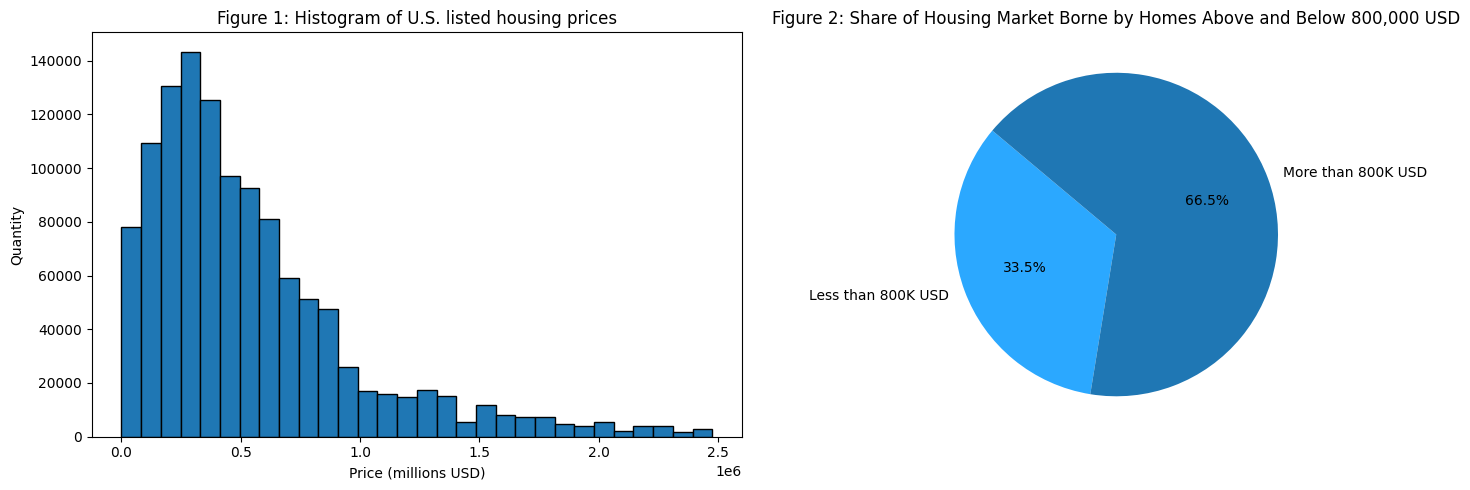

In [79]:
#plotting data for price distribution
fig, fig_price = plt.subplots(1,2,figsize=(15,5))

fig_price[0].hist(data['price'],bins=30,edgecolor='black')
fig_price[0].set_title("Figure 1: Histogram of U.S. listed housing prices")
fig_price[0].set_ylabel("Quantity")
fig_price[0].set_xlabel("Price (millions USD)")

#creating pie-chart showing quantity contributed by homes above vs. below 75th percentile ($700,000)
below_75th = df[df['price'] < 800000]['price'].sum()
above_75th = df[df['price'] >= 800000]['price'].sum()
# Preparing data for the pie chart
prices = [below_75th, above_75th]
labels = ['Less than 800K USD', 'More than 800K USD']

fig_price[1].pie(prices, labels=labels, autopct='%1.1f%%',startangle=140,colors=['#2ba8ff','#1f77b4'])
fig_price[1].set_title("Figure 2: Share of Housing Market Borne by Homes Above and Below 800,000 USD")

plt.tight_layout()

Figure 1 depicts the histogram for U.S. listed housing prices, with extreme outliers removed. The graph clearly shows a positively skewed distribution, with a single mode. This skewed distribution displays the large amount of homes valued between 0 USD and ~800,000 USD (75th percentile of price in unfiltered data), which make up the majority of the U.S. home market in terms of quantity. Given the large quantity of homes within this price range, it would not be unexpected to see a more competitive industry for homes under 800,000 USD vs those above 800,000 USD. This becomes more interesting when you consider the information within Figure 2. Even though 75% of properties are valued at less than 800,000 USD, those properties only make up 33.5% of the total market value of the dataset. The high-end real estate market contains the majority of the entire market's value.

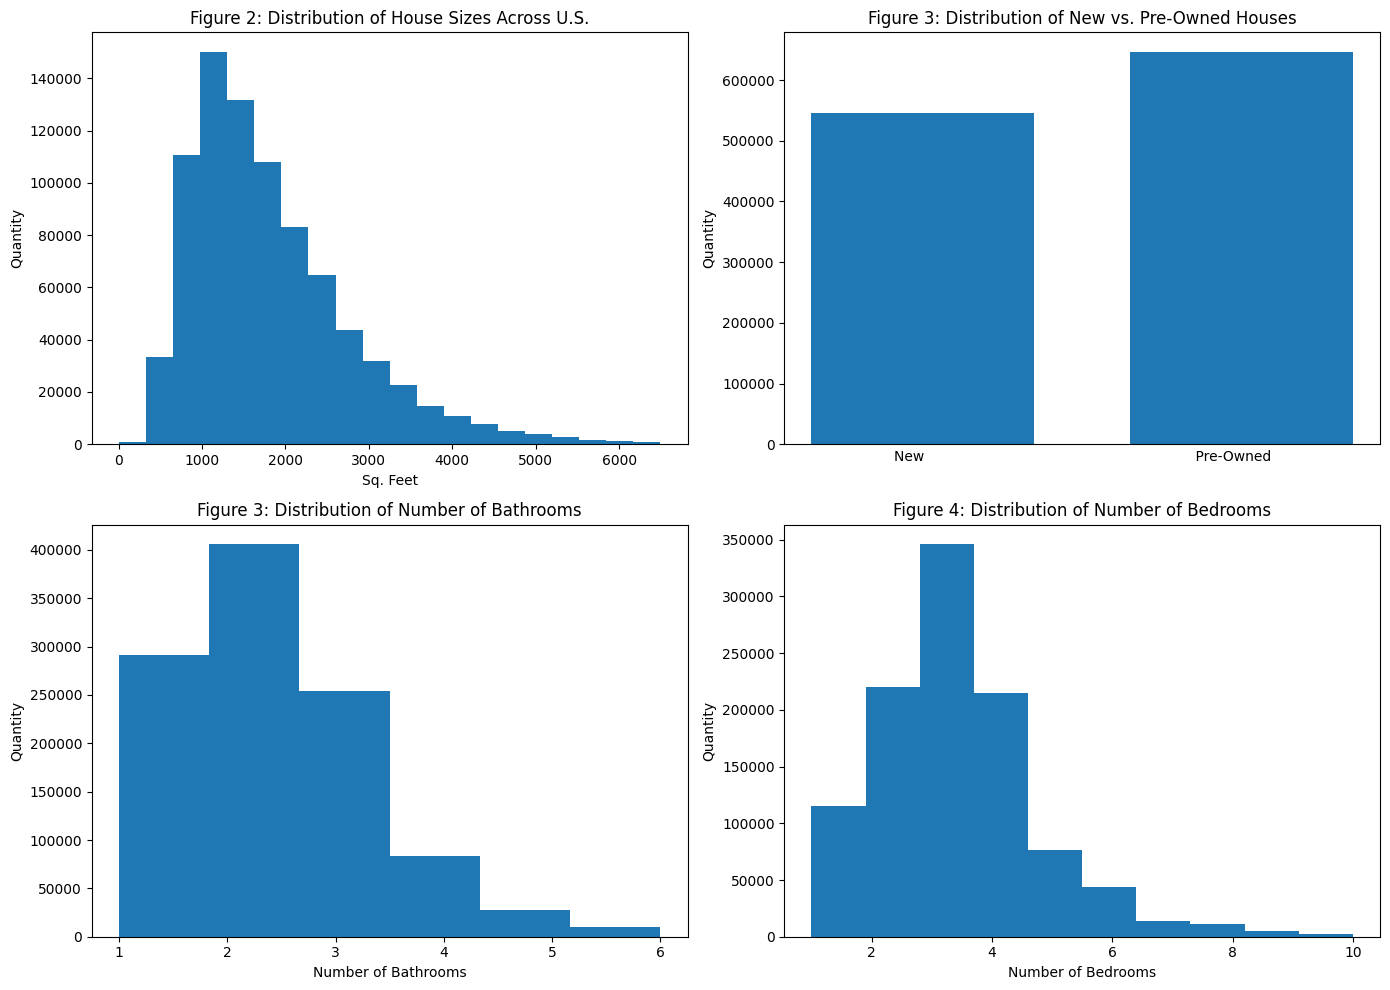

In [80]:
fig, fig_1 = plt.subplots(2,2,figsize=(14,10))

#plotting histogram for house_size
fig_1[0,0].hist(data["house_size"], bins=20)
fig_1[0,0].set_title("Figure 2: Distribution of House Sizes Across U.S.")
fig_1[0,0].set_xlabel('Sq. Feet')
fig_1[0,0].set_ylabel('Quantity')

#plotting histogram for sold_before 
fig_1[0,1].hist(data["sold_before"], bins=2, rwidth=0.7, align='mid')
fig_1[0,1].set_title("Figure 3: Distribution of New vs. Pre-Owned Houses")
#customising x-axis for dummy
fig_1[0,1].set_xticks([])
fig_1[0,1].set_xlabel('New                                                              Pre-Owned')
fig_1[0,1].set_ylabel('Quantity')

#plotting histogram for # of baths
fig_1[1,0].hist(data['bath'], bins=6)
fig_1[1,0].set_title("Figure 3: Distribution of Number of Bathrooms")
fig_1[1,0].set_xlabel('Number of Bathrooms')
fig_1[1,0].set_ylabel('Quantity')

#plotting histogram for # of bedrooms
fig_1[1,1].hist(data['bed'], bins=10)
fig_1[1,1].set_title("Figure 4: Distribution of Number of Bedrooms")
fig_1[1,1].set_xlabel('Number of Bedrooms')
fig_1[1,1].set_ylabel('Quantity')

plt.tight_layout()

PHF 3 - describe histograms

PHF 4 - introduce more complex graphs for New-York, New-Jersey, Massachusetts, and Connecticut

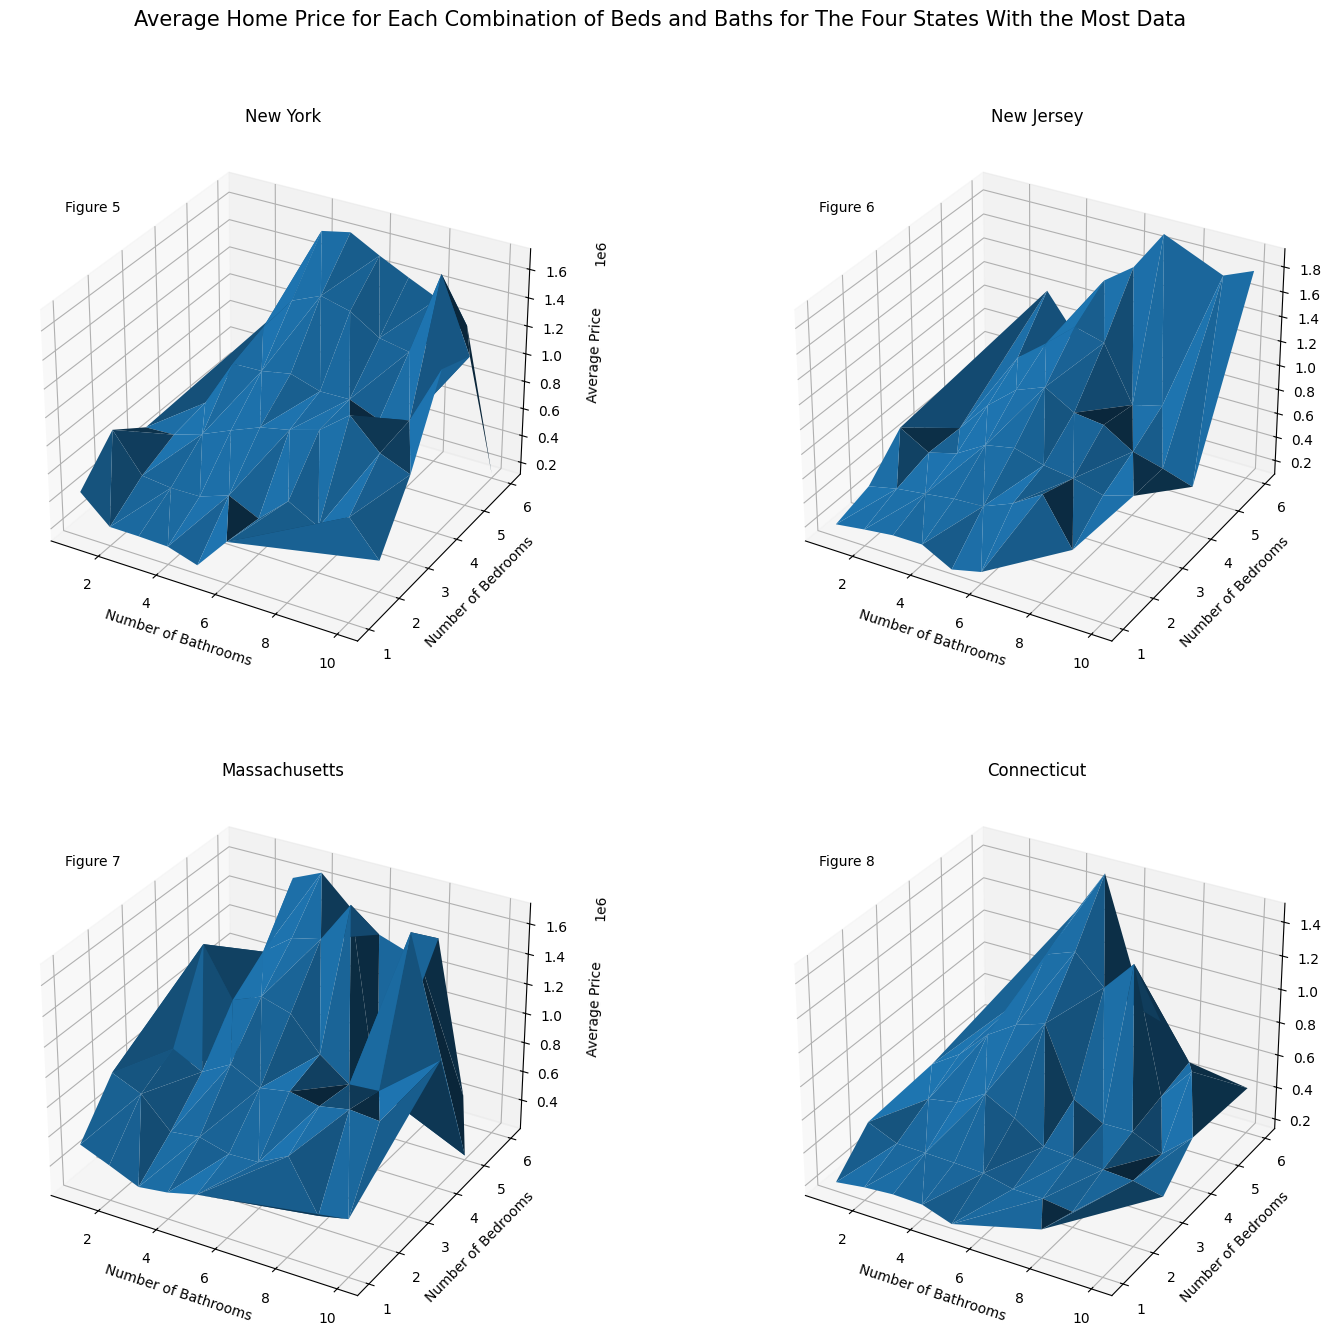

In [37]:
def prepare_and_plot(state, subplot_position, fig, data_by_state):
    pivot_table = data_by_state.get_group(state).pivot_table(values='price', index='bed', columns='bath', aggfunc='mean')
    pivot_table = pivot_table.stack().reset_index()
    pivot_table.columns = ['bed', 'bath', 'average_price']

    beds = pivot_table['bed']
    baths = pivot_table['bath']
    average_price = pivot_table['average_price']

    ax = fig.add_subplot(2, 2, subplot_position, projection='3d')
    ax.plot_trisurf(beds, baths, average_price)
    ax.set_xlabel('Number of Bathrooms')
    ax.set_ylabel('Number of Bedrooms')
    ax.set_zlabel('Average Price', fontsize=10, labelpad=10) 
    ax.set_title(state)

    # Add figure label if needed, e.g., 'A', 'B', 'C', 'D'
    ax.text2D(0.1, 0.85, f'Figure {subplot_position + 4}', transform=ax.transAxes)

fig_2 = plt.figure(figsize=(18, 15))
#Title for whole figure
fig_2.suptitle('Average Home Price for Each Combination of Beds and Baths for The Four States With the Most Data', fontsize=15)

states = ['New York', 'New Jersey', 'Massachusetts', 'Connecticut']

for i, state in enumerate(states, start=1):
    prepare_and_plot(state, i, fig_2, data_by_state)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.2)

plt.show()

In [5]:
grouped = data.groupby(['bed', 'bath']).mean().reset_index()

# Step 2: Create the Heatmap
# Create a pivot table
pivot_table = grouped.pivot('bed', 'bath', 'price')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Average Home Price by Number of Bedrooms and Bathrooms")
plt.xlabel("Number of Bathrooms")
plt.ylabel("Number of Bedrooms")
plt.show()

NameError: name 'data' is not defined